In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[5.7125e-16, 8.5981e-01, 1.3561e-06, 2.1668e-04, 2.2881e-06, 1.0129e-02,
          1.2434e-01, 5.4963e-03, 9.7210e-10, 7.6918e-10]]),
 tensor([[3.2632e-04, 3.5413e-01, 2.4476e-02, 6.7521e-02, 2.7175e-02, 1.4568e-01,
          2.4055e-01, 1.2891e-01, 5.7520e-03, 5.4889e-03]]),
 tensor([[0.0070, 0.2311, 0.0607, 0.1009, 0.0640, 0.1482, 0.1904, 0.1394, 0.0294,
          0.0288]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

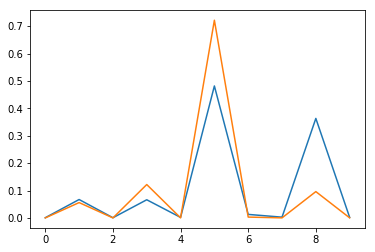

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [22]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [23]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [24]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [25]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie0.h5'),EarlyStopping(10)])

1: Train=385.3938702392578 Valid=375.5210974121094
2: Train=352.69574951171876 Valid=350.5716442871094
3: Train=335.12011962890625 Valid=337.8391143798828
4: Train=327.5149882507324 Valid=332.3481494140625
5: Train=322.61208984375 Valid=328.0092535400391
6: Train=319.31162506103516 Valid=324.18119873046874
7: Train=316.11224609375 Valid=321.26806274414065
8: Train=312.82358215332033 Valid=318.0329321289062
9: Train=309.95378494262695 Valid=314.60944396972656
10: Train=306.78124450683595 Valid=311.05070251464844
11: Train=303.422057800293 Valid=307.80402587890626
12: Train=300.7745634460449 Valid=304.99571838378904
13: Train=298.1020706176758 Valid=302.7683880615234
14: Train=295.7732290649414 Valid=300.9159454345703
15: Train=294.3520040893555 Valid=298.90134582519534
16: Train=292.2635974121094 Valid=297.2924279785156
17: Train=290.91453155517576 Valid=295.2695886230469
18: Train=289.00959182739257 Valid=293.1248895263672
19: Train=287.3169624328613 Valid=291.87222381591795
20: Train=

155: Train=241.65960159301758 Valid=247.8158236694336
156: Train=241.71777908325194 Valid=247.78915710449218
157: Train=241.75766510009765 Valid=247.4874105834961
158: Train=241.53393951416015 Valid=247.76609069824218
159: Train=241.32015930175783 Valid=247.43424530029296
160: Train=241.3224542236328 Valid=247.51148986816406
161: Train=241.26059265136718 Valid=247.36746032714845
162: Train=240.9090089416504 Valid=247.51967254638672
163: Train=241.05498641967773 Valid=247.36999542236327
164: Train=240.7728291320801 Valid=247.0239306640625
165: Train=241.0789367675781 Valid=247.38220184326173
166: Train=241.0213331604004 Valid=247.2287503051758
167: Train=240.77848495483397 Valid=247.13746154785156
168: Train=240.84329360961914 Valid=247.07627471923828
169: Train=240.74184585571288 Valid=246.91124725341797
170: Train=240.58863494873046 Valid=247.1717221069336
171: Train=240.80091888427734 Valid=246.86666870117188
172: Train=240.67348724365235 Valid=246.8864453125
173: Train=240.508703765

In [26]:
model.save('weights/Inferno_Test_exact_bm0.h5')

In [17]:
model.load('weights/Inferno_Test_exact_bm0.h5')

# Results

In [27]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [28]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [29]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,9,1.0
2,5,1.0
3,9,1.0
4,9,1.0


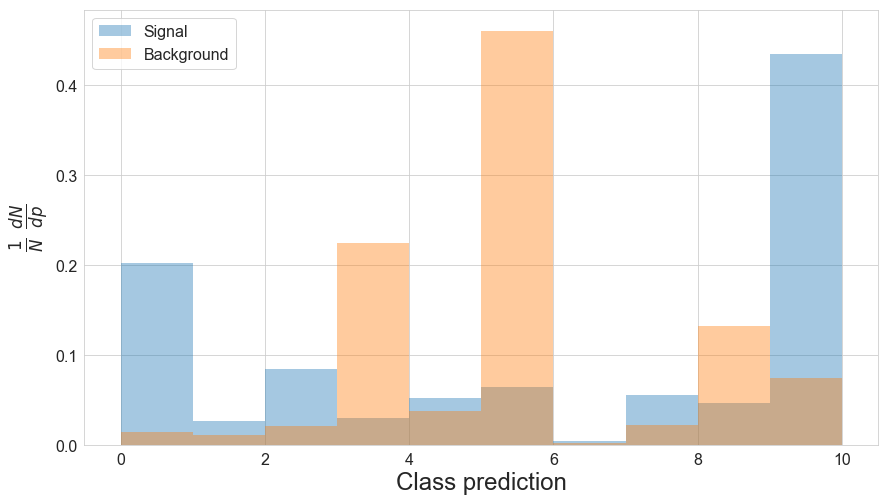

In [30]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [31]:
bin_preds(df)

In [32]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,9,1.0,9
2,5,1.0,5
3,9,1.0,9
4,9,1.0,9


In [33]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [34]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.))

In [35]:
f_s, f_b

(tensor([0.2025, 0.0261, 0.0840, 0.0296, 0.0518, 0.0648, 0.0041, 0.0556, 0.0464,
         0.4351]),
 tensor([0.0146, 0.0106, 0.0211, 0.2249, 0.0376, 0.4609, 0.0024, 0.0218, 0.1318,
         0.0743]))

In [36]:
asimov = (50*f_s)+(1000*f_b)

In [37]:
asimov, asimov.sum()

(tensor([ 24.7226,  11.9117,  25.2898, 226.3794,  40.1561, 464.1080,   2.6314,
          24.5680, 134.1539,  96.0791]), tensor(1050.))

In [38]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([30.28471184, 30.13497925, 29.99147797, 29.85408783, 29.7222805 ,
       29.59692192, 29.47684479, 29.3627243 , 29.25415611, 29.15121078,
       29.05374718, 28.96147919, 28.87431717, 28.79256439, 28.71637726,
       28.64486885, 28.57868004, 28.5171566 , 28.46072006, 28.40904236,
       28.36243439, 28.31990814, 28.2826786 , 28.24969864, 28.22125435,
       28.19730186, 28.17808533, 28.16347122, 28.15273476, 28.14657402,
       28.14404106, 28.14620209, 28.15254784, 28.16265869, 28.177351  ,
       28.19548416, 28.21808815, 28.24436188, 28.27443504, 28.30841446,
       28.34619141, 28.38769341, 28.43310165, 28.4818821 , 28.53451538,
       28.59062386, 28.65042114, 28.71377563, 28.7806778 , 28.85086823,
       28.92434883, 29.00161743, 29.08202553, 29.16576195, 29.25270844,
       29.34320641, 29.43666458, 29.53346252, 29.63334084, 29.73616409,
       29.84228706])

In [39]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [40]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

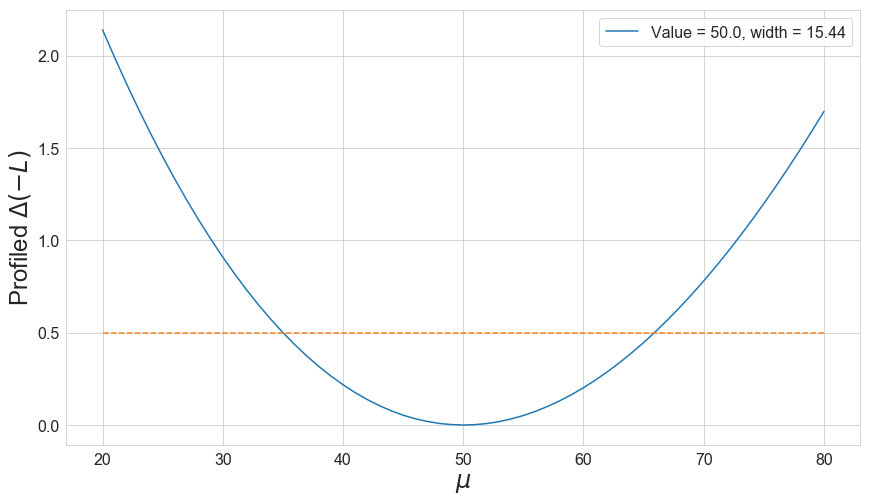

In [41]:
plot_likelihood(y-y.min())

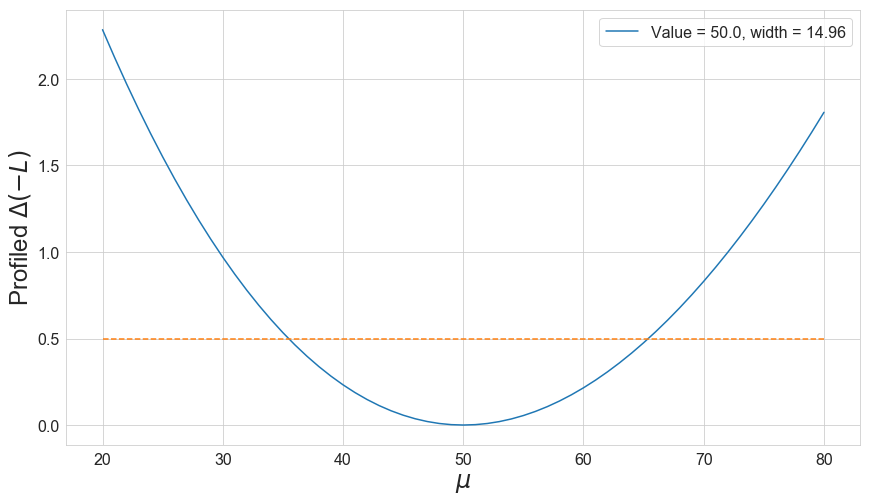

In [42]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [43]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [44]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [45]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,9,1.0,9,9,9,9,9,9,9,9,9,9,9
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,9,1.0,9,9,9,9,9,9,9,9,9,9,9
4,9,1.0,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999997,9,0.0,9,9,9,9,9,8,8,9,9,9,9
999998,9,0.0,9,9,9,9,9,9,9,9,9,9,9


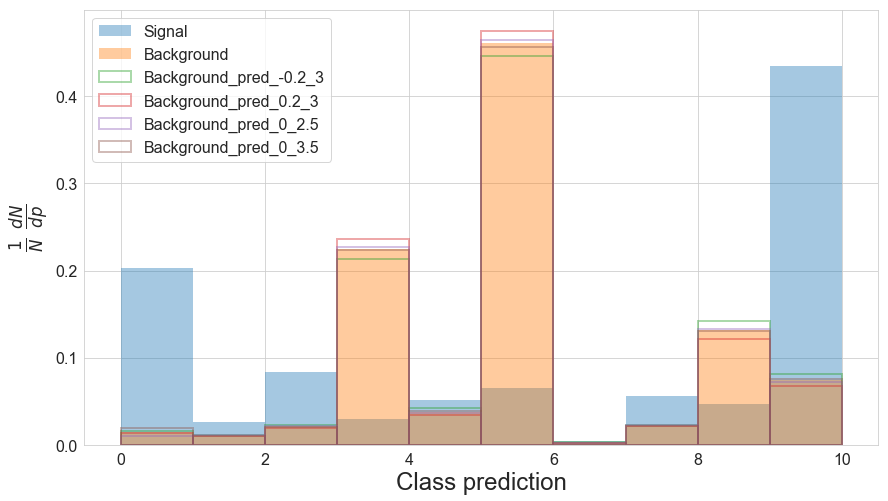

In [46]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.0117, 0.0113, 0.0232, 0.2147, 0.0413, 0.4502, 0.0030, 0.0227, 0.1432,
        0.0787])
tensor([0.0160, 0.0112, 0.0228, 0.2132, 0.0422, 0.4462, 0.0030, 0.0224, 0.1424,
        0.0807])
tensor([0.0209, 0.0109, 0.0225, 0.2116, 0.0434, 0.4422, 0.0029, 0.0221, 0.1416,
        0.0819])
tensor([0.0103, 0.0108, 0.0214, 0.2265, 0.0366, 0.4649, 0.0024, 0.0222, 0.1326,
        0.0723])
tensor([0.0146, 0.0106, 0.0211, 0.2249, 0.0376, 0.4609, 0.0024, 0.0218, 0.1318,
        0.0743])
tensor([0.0195, 0.0104, 0.0208, 0.2233, 0.0387, 0.4568, 0.0024, 0.0216, 0.1310,
        0.0755])
tensor([0.0092, 0.0104, 0.0198, 0.2375, 0.0329, 0.4793, 0.0020, 0.0216, 0.1222,
        0.0652])
tensor([0.0135, 0.0103, 0.0194, 0.2359, 0.0338, 0.4753, 0.0020, 0.0212, 0.1214,
        0.0672])
tensor([0.0184, 0.0101, 0.0192, 0.2343, 0.0349, 0.4712, 0.0019, 0.0210, 0.1205,
        0.0684])


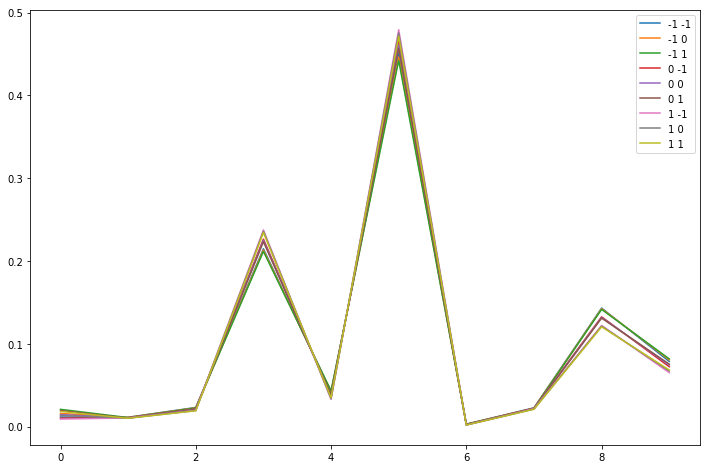

In [47]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [48]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [49]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [50]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [51]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [52]:
nll = to_np(nll)

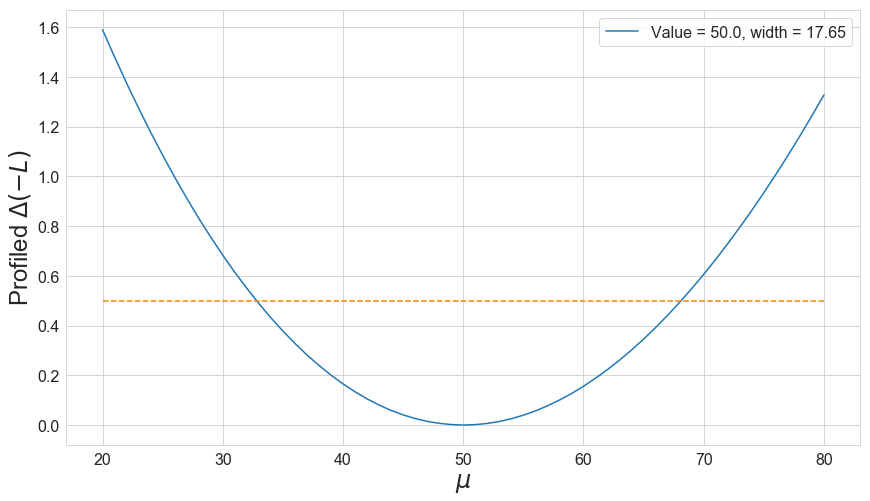

In [53]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [54]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [55]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.2259])
Linear regime: Mu 21.0, alpha tensor([1.1847])
Linear regime: Mu 22.0, alpha tensor([1.1435])
Linear regime: Mu 23.0, alpha tensor([1.1023])
Linear regime: Mu 24.0, alpha tensor([1.0612])
Linear regime: Mu 71.0, alpha tensor([-1.0004])
Linear regime: Mu 72.0, alpha tensor([-1.0478])
Linear regime: Mu 73.0, alpha tensor([-1.0951])
Linear regime: Mu 74.0, alpha tensor([-1.1424])
Linear regime: Mu 75.0, alpha tensor([-1.1897])
Linear regime: Mu 76.0, alpha tensor([-1.2370])
Linear regime: Mu 77.0, alpha tensor([-1.2842])
Linear regime: Mu 78.0, alpha tensor([-1.3315])
Linear regime: Mu 79.0, alpha tensor([-1.3787])
Linear regime: Mu 80.0, alpha tensor([-1.4258])


In [56]:
nll = to_np(nll)

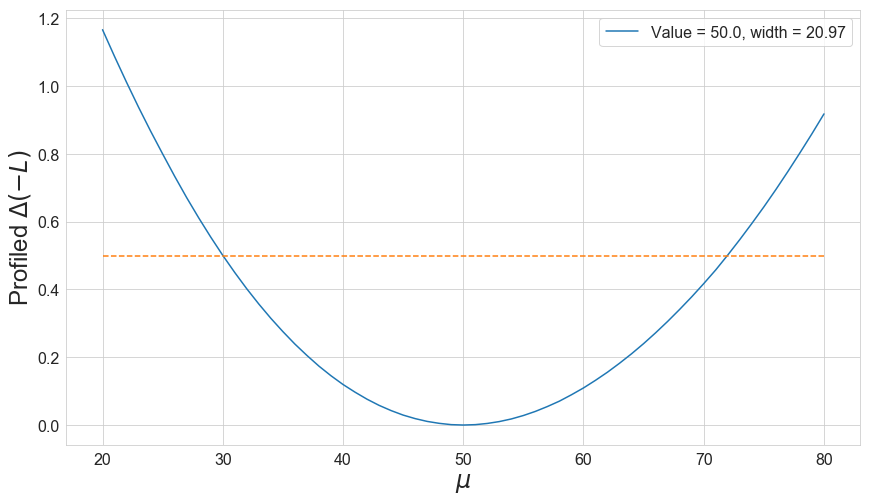

In [57]:
plot_likelihood(nll-nll.min())

## BM 2

In [58]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3606,  1.0289])
Linear regime: Mu 74.0, alpha tensor([ 0.2418, -1.0022])
Linear regime: Mu 75.0, alpha tensor([ 0.2535, -1.0340])
Linear regime: Mu 76.0, alpha tensor([ 0.2634, -1.0754])
Linear regime: Mu 77.0, alpha tensor([ 0.2733, -1.1168])
Linear regime: Mu 78.0, alpha tensor([ 0.2832, -1.1582])
Linear regime: Mu 79.0, alpha tensor([ 0.2930, -1.1996])
Linear regime: Mu 80.0, alpha tensor([ 0.3029, -1.2410])


In [59]:
nll = to_np(nll)

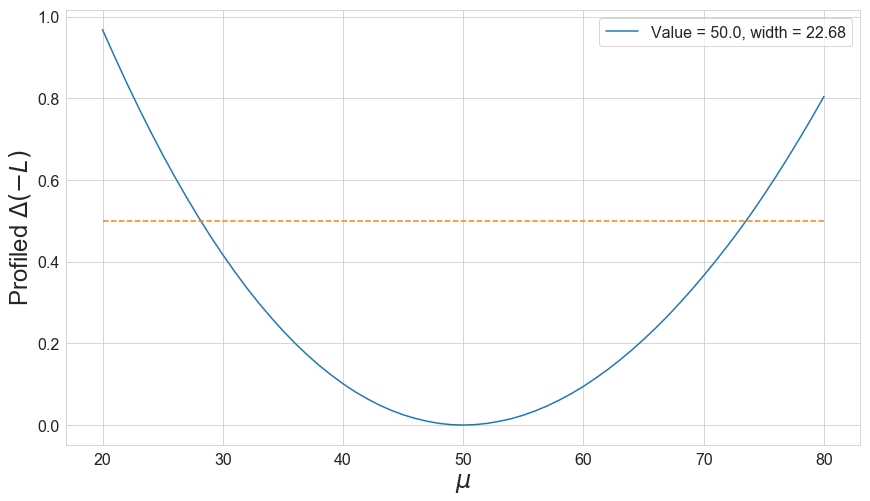

In [60]:
plot_likelihood(nll-nll.min())